# Classification

## Examples

### Basic imports and data load

In [86]:
import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape

(60000, 28, 28)

In [3]:
train_images = train_images.reshape(60000, 28 * 28)
test_images = test_images.reshape(10000, 28 * 28)
train_images.shape

(60000, 784)

In [4]:
def draw_image(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")

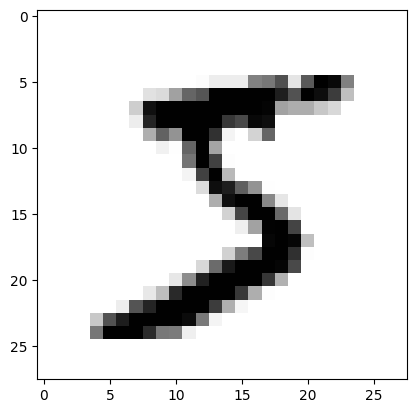

In [5]:
draw_image(train_images[0])

### Binary classification

Consider a specific case, for example if given image is a 5 or not to simplify the problem

In [6]:
y_test_5 = (test_labels == 5)
y_train_5 = (train_labels == 5)

In [7]:
sgd = SGDClassifier()
sgd.fit(train_images, y_train_5)


SGDClassifier()

[False]


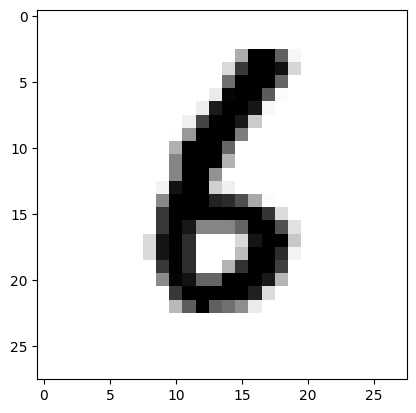

In [8]:
img = random.choice(test_images)
print(sgd.predict(img.reshape(1, -1)))
draw_image(img)

#### Metrics

In [9]:
cross_val_score(sgd, test_images, y_test_5, cv = 3, scoring = "accuracy")

array([0.90611878, 0.90729073, 0.96639664])

In [10]:
y_train_predicted = cross_val_predict(sgd, train_images, y_train_5, cv = 3)

Generally, accuracy is not the best metric as datasets can vary. One should consider confustion matrices

In [11]:
cmatr = confusion_matrix(y_train_5, y_train_predicted)
cmatr

array([[53614,   965],
       [ 1203,  4218]])

Confusion matrices follow the following structure (binary case):

| Actual\Predicted | Predicted Positive | Predicted Negative |
|-------------------|--------------------|--------------------|
| Actual Positive   | True Positive (TP) | False Negative (FN) |
| Actual Negative   | False Positive (FP) | True Negative (TN) |

There are other metrics used to check how good the model performs
$$\text{precision} = {TP\over TP + FP}$$
$$\text{recall} = {TP\over TP + FN}$$
$$ F_1 = 2{{\text{recall} \cdot {\text{precision}}\over{\text{recall} + \text{precision}}}}$$

In [12]:
print(f"""recall = {recall_score(y_train_5, y_train_predicted)}  
precision = {precision_score(y_train_5, y_train_predicted)}
f1 = {f1_score(y_train_5, y_train_predicted)}""")

recall = 0.7780852241283895  
precision = 0.8138143932085665
f1 = 0.7955488494907582


Depending on the task, one can be interested in either high accuraccy or recall, so there's a thing called "precision/recall tradeoff", where certain threshold must be chosen, which will impact the classification results

In [13]:
y_scores = cross_val_predict(sgd, train_images, y_train_5, cv = 3, method = "decision_function")

In [14]:
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

(the plot is stolen from the book itself)

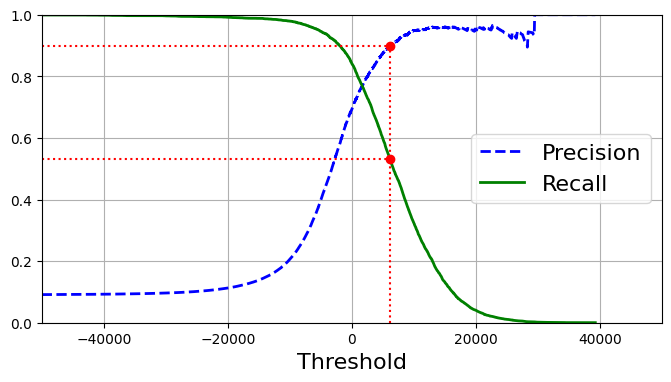

In [15]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recall[np.argmax(precision >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precision >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown

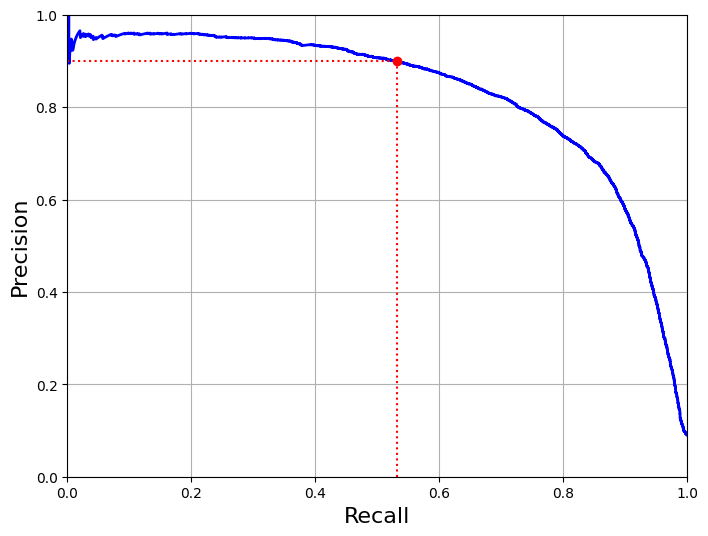

In [16]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precision, recall)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [17]:
idxs = (precision >= 0.90).argmax()
thr_90 = thresholds[idxs]
thr_90

np.float64(6203.029131654038)

In [18]:
y_train_thr_90 = (y_scores >= thr_90)
print(f""" prec = {precision_score(y_train_5, y_train_thr_90)}
recall = {recall_score(y_train_5, y_train_thr_90)}""")

 prec = 0.9000624609618988
recall = 0.5316362294779561


#### The ROC curve

ROC - receiver operating characteristic curve

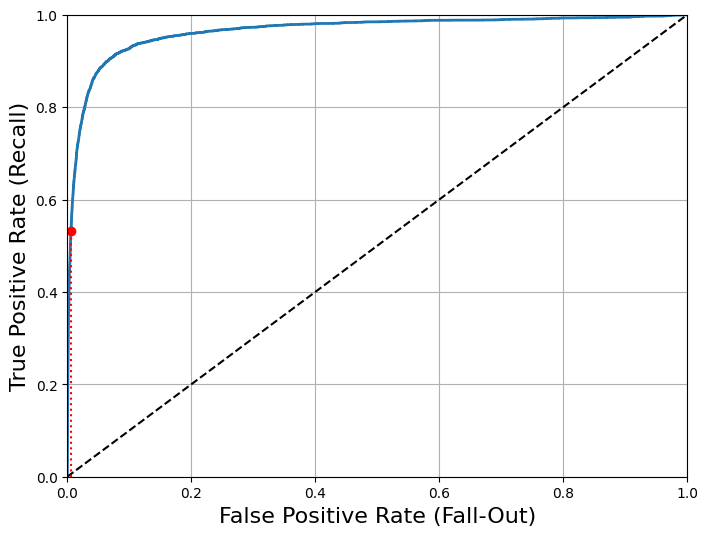

In [19]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [20]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9648143342591401)

Consider another classifier and compare it with SGD

In [21]:
forest = RandomForestClassifier()
y_forest = cross_val_predict(forest, train_images, y_train_5, cv = 3, method = "predict_proba")
y_forest[:2]

array([[0.19, 0.81],
       [1.  , 0.  ]])

In [22]:
y_forest_scores = y_forest[:, 1]
prec, rec, thr = precision_recall_curve(y_train_5, y_forest_scores)

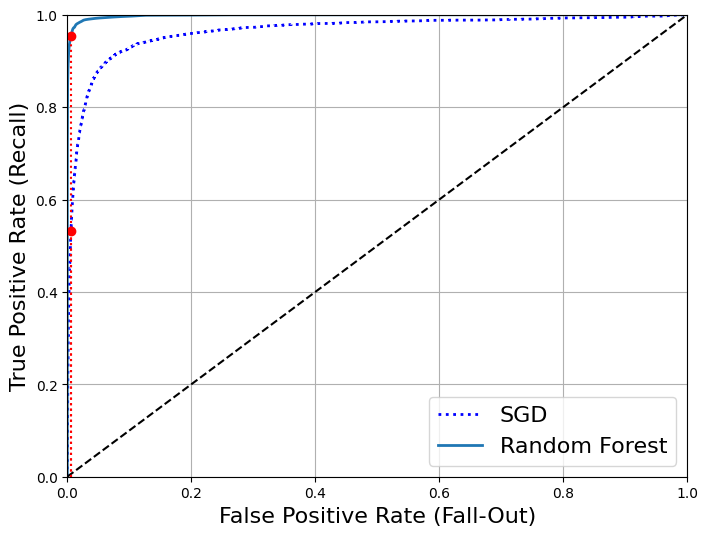

In [23]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_forest_scores)
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
# save_fig("roc_curve_comparison_plot")
plt.show()

### Multiclass classification

In [25]:
svm = SVC()
svm.fit(train_images[:2000], train_labels[:2000])
    

SVC()

[[ 9.30592593 -0.29824289  5.03727237  7.20230098  0.73514868  8.24823857
   4.1179789   1.72648918  6.17084559  2.90312807]]


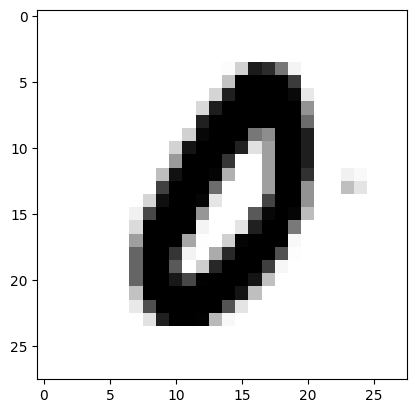

In [30]:
fig = random.choice(train_images).reshape(1, -1)
print(svm.decision_function(fig))
draw_image(fig)

In [31]:
svm.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

One can manually tell scikit to use OvO or OvR

In [33]:
ovr = OneVsRestClassifier(SVC())
ovr.fit(train_images[:2000], train_labels[:2000])

OneVsRestClassifier(estimator=SVC())

[[-1.93149321  0.144499   -1.31765067 -1.65899016 -2.23389686 -1.6122401
  -1.10096576 -1.35968557 -0.08130989 -1.59154052]]


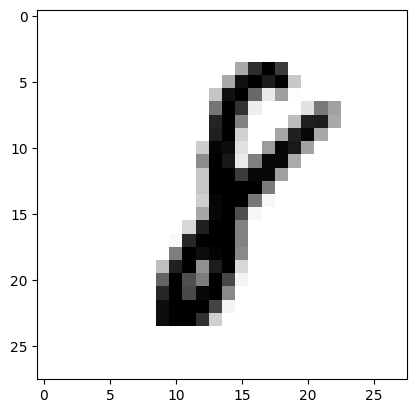

In [40]:
fig = random.choice(train_images).reshape(1, -1)
print(ovr.decision_function(fig))
draw_image(fig)

Previously used SGD classifier can be used for multiclass classification easilly as well.

In [47]:
sgd = SGDClassifier()
sgd.fit(train_images[:2000], train_labels[:2000])

SGDClassifier()

[4]
[[-2830685.59261789 -4056032.32337584 -1585970.26498807  -754842.00582127
    224808.67674716 -1573255.09871504 -1248436.4362522   -415012.30671092
   -537054.67579705  -453752.42042946]]


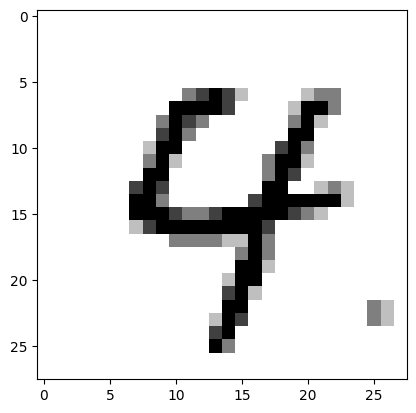

In [58]:
fig = random.choice(train_images).reshape(1, -1)
print(sgd.predict(fig))
print(sgd.decision_function(fig))
draw_image(fig)

In [61]:
cross_val_score(sgd, train_images[:2000], train_labels[:2000], cv = 3, scoring = "accuracy")

array([0.84857571, 0.81709145, 0.85135135])

Norm score :thumbs_up:

Adapting the inputs can increase the score

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_images.astype("float64"))
cross_val_score(sgd, X_train_scaled[:2000], train_labels[:2000], cv=3, scoring="accuracy")

array([0.85607196, 0.82308846, 0.86636637])

### Error analysis

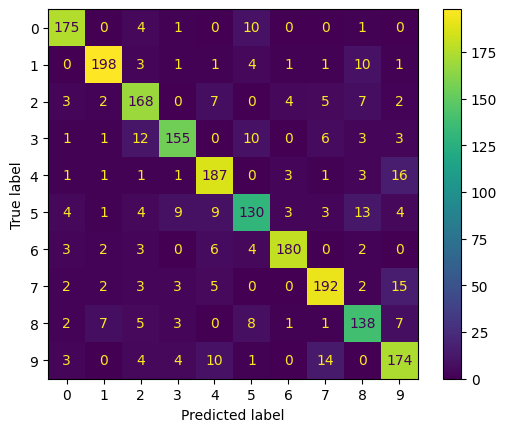

In [64]:
y_train_predicted = cross_val_predict(sgd, X_train_scaled[:2000], train_labels[:2000], cv = 3)
ConfusionMatrixDisplay.from_predictions(train_labels[:2000], y_train_predicted[:2000])

It's better to normalize, because datasets can differ and be imbalanced

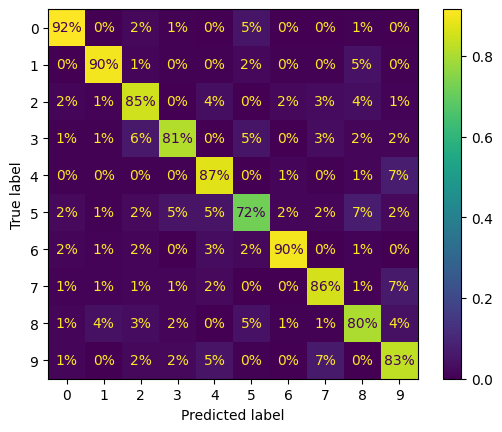

In [65]:
ConfusionMatrixDisplay.from_predictions(train_labels[:2000], y_train_predicted[:2000], normalize="true", values_format=".0%")

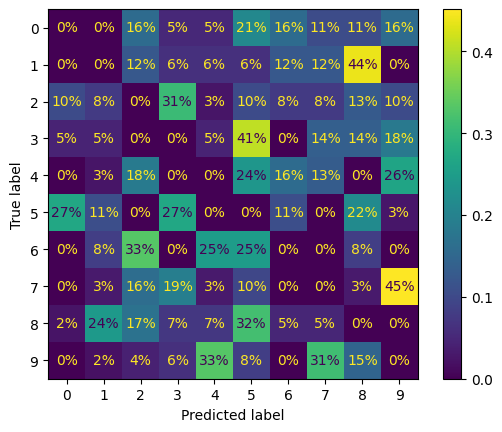

In [66]:
sample_weight = (y_train_predicted[:2000] != train_labels[:2000])
ConfusionMatrixDisplay.from_predictions(y_train_predicted[:2000], train_labels[:2000],
 sample_weight=sample_weight,
 normalize="true", values_format=".0%")

The graph above makes it easier to see what the model misclassifies the most

### Multilabel classification

In [69]:
y_train_large = (train_labels >= 7)
y_train_odd = (train_labels % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn = KNeighborsClassifier()
knn.fit(train_images, y_multilabel)

KNeighborsClassifier()

[[False False]]


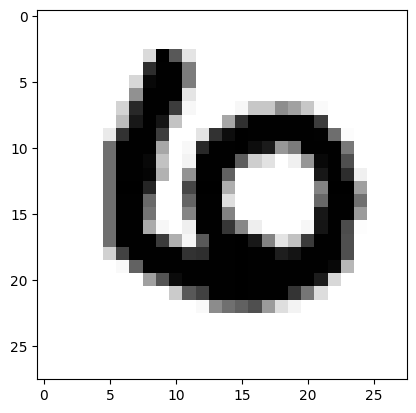

In [81]:
fig = random.choice(train_images).reshape(1, -1)
print(knn.predict(fig))
# print(knn.decision_function(fig))
draw_image(fig)

There are a lot of ways to choose metrics for multilabel classifiers

In [83]:
y_train_knn_pred = cross_val_predict(knn, train_images[:5000], y_multilabel[:5000], cv=3)

In [85]:
f1_score(y_multilabel[:5000], y_train_knn_pred, average="macro")

0.9459349842547329

One can even create a multi-label classifiers for which the classification initially is not supported

In [87]:
chain = ClassifierChain(SVC(), cv = 3)
chain.fit(train_images[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3)

[[1. 1.]]


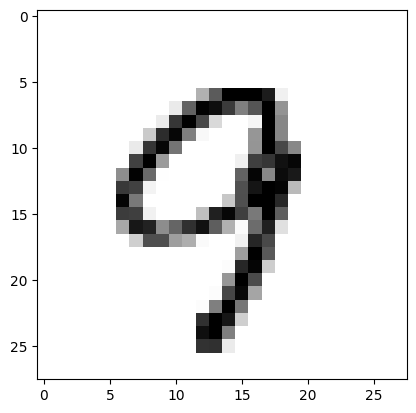

In [96]:
fig = random.choice(train_images).reshape(1, -1)
print(chain.predict(fig))
draw_image(fig)

### Multioutput classification

## Exercises

In [99]:
noise = np.random.randint(0, 100, (len(train_images), 784))
X_train = train_images + noise
noise = np.random.randint(0, 100, (len(test_images), 784))
X_test = test_images + noise

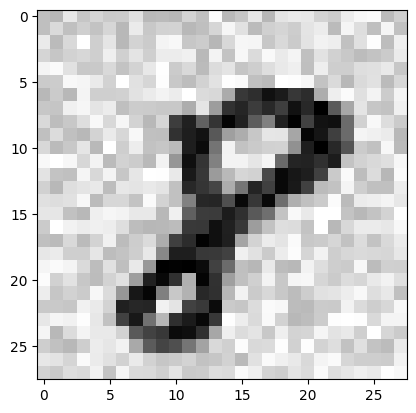

In [102]:
fig = random.choice(X_train)
draw_image(fig)

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_images)

ValueError: Found input variables with inconsistent numbers of samples: [60000, 10000]

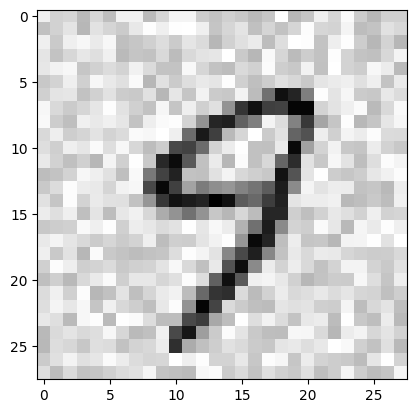

In [134]:
fig = random.choice(X_test)
draw_image(fig)

In [142]:
fig = np.array(fig)
fig.shape
# fig.reshape(28, 28)
knn.predict(fig).shape


(1,)